## 1. Data description (REUSED)

For this project, I use my own voice messages that I’ve sent to my friends and family over the past few years. I speak both Kazakh and Russian, and I often switch between them depending on who I’m talking to. My international friends sometimes try to guess which language I’m speaking, so I thought it would be fun to see if a computer could do a better job than they do.

To build my dataset, I went through my Telegram and WhatsApp chat histories, and listened to old voice messages. From there, I selected clips where I speak clearly in one language without too much background noise. Because I often mix languages within a message, finding clean, single-language clips was challenging. To respect privacy, I excluded any recordings that contained personal or sensitive information, keeping only everyday conversations, greetings, and casual stories.

For Assignment 1 I sampled 20 Kazakh and 20 Russian messages and treated each full message as one data point. In this second pipeline I reuse the exact same 40 recordings, but I change how I sample from them (see Section 3).

All audio files were converted to `.wav` using FFmpeg so that:

- every file has a consistent sampling rate,  
- the files are easy to load with `librosa` in Python.

The files are stored in two folders (`kazakh/` and `russian/`) and renamed with a simple convention such as `kazakh_01.wav` and `russian_01.wav`.

## 2. Loading the data (REUSED)

To make the audio usable in Python and scikit-learn, I first mount my Google Drive in Colab and collect all `.wav` files from the Kazakh and Russian folders.

For each file I store:

- `filepath`: full path to the `.wav` file in Drive,
- `file_id`: a short identifier such as `kazakh_01`,
- `language`: `"kazakh"` or `"russian"`,
- `label`: numeric label (`0` for Kazakh, `1` for Russian).

These entries are stored in a `pandas` DataFrame and serve as a starting point for the rest of the pipeline. It lets me iterate over recordings, load each waveform with `librosa`, and attach all later features and metadata.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import all the necessary libraries
import os
import glob
import numpy as np
import pandas as pd
import librosa
import librosa.display
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, auc
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random
import seaborn as sns
import copy

# reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


In [ ]:
# define the paths to my folders
kazakh_path = "/content/drive/MyDrive/data/kazakh/"
russian_path = "/content/drive/MyDrive/data/russian/"

# collect all file paths
kazakh_files = sorted(glob.glob(os.path.join(kazakh_path, "*.wav")))
russian_files = sorted(glob.glob(os.path.join(russian_path, "*.wav")))

print(f"Found {len(kazakh_files)} Kazakh recordings")
print(f"Found {len(russian_files)} Russian recordings")

# create a DataFrame that lists each file and its label
data = []

for file in kazakh_files:
    base = os.path.basename(file)                     # "kazakh_01.wav"
    file_id = os.path.splitext(base)[0]               # "kazakh_01"
    data.append({
        "filepath": file,
        "file_id": file_id,
        "language": "kazakh",
        "label": 0
    })

for file in russian_files:
    base = os.path.basename(file)
    file_id = os.path.splitext(base)[0]
    data.append({
        "filepath": file,
        "file_id": file_id,
        "language": "russian",
        "label": 1
    })

df = pd.DataFrame(data)

# preview the dataset structure
df = pd.DataFrame(data)
df.head()


Found 20 Kazakh recordings
Found 20 Russian recordings


,filepath,file_id,language,label
0,/content/drive/MyDrive/data/kazakh/kazakh_01.wav,kazakh_01,kazakh,0
1,/content/drive/MyDrive/data/kazakh/kazakh_02.wav,kazakh_02,kazakh,0
2,/content/drive/MyDrive/data/kazakh/kazakh_03.wav,kazakh_03,kazakh,0
3,/content/drive/MyDrive/data/kazakh/kazakh_04.wav,kazakh_04,kazakh,0
4,/content/drive/MyDrive/data/kazakh/kazakh_05.wav,kazakh_05,kazakh,0


## 3. Preprocessing, feature engineering, and exploratory data analysis (UPDATED)

### 3.1 Chunking

In my first pipeline I treated each full voice message as a single data point. It turned out to be a bad sampling choice because it left me with only 8 test samples. That made the evaluation extremely unstable because one misclassified clip already changed test accuracy by more than 10%.

For this second pipeline I keep the same 40 original recordings, but I change the sampling strategy:

- I resample every file to a mono 16 kHz signal.
- I split each waveform into fixed-length 2-second chunks.
- I allow 25% overlap between consecutive chunks to avoid losing information at the boundaries.
- If the last chunk is shorter than 2 seconds, I zero-pad it to full length.

I ended up having 553 chunks in total. Each row in the metadata table `meta_df` now corresponds to a single chunk and stores:

- `file_id`: which original recording it came from,
- `chunk_index`: which chunk within that recording,
- `label`: 0 for Kazakh, 1 for Russian.

Now the dataset is large enough to reliably evaluate the models.


### 3.2 Feature engineering

For the logistic regression (baseline) model, I kept a  set of summary features for each chunk. From each MFCC matrix and waveform I extracted:

- mean of each MFCC coefficient,
- standard deviation of each MFCC coefficient,
- mean zero-crossing rate (ZCR),
- mean spectral centroid,
- mean RMS (energy).

However, for the deep learning models (CNN/LSTM), I needed to preserve the temporal structure. Thus, I extracted 40 MFCCs for every time frame, resulting in a matrix of shape $(40 \times T)$, where $T$ is the number of time frames.

I then normalized each MFCC coefficient across time by subtracting its mean, and dividing by its standard deviation (plus a small epsilon for numerical stability). As a result, I got an array `mfcc_array` with shape:

- `(N_chunks, 40, T)` for the raw MFCCs,
- and later `(N_chunks, 1, 40, T)` when I add a channel dimension for the CNN.

Visually, each MFCC matrix looks like a small grayscale image where: the vertical axis is frequency (cepstral coefficients), and the horizontal axis is time.

In [ ]:
SR = 16_000                 # target sampling rate (consistent for all files)
CHUNK_SECONDS = 2.0
CHUNK_SAMPLES = int(SR * CHUNK_SECONDS)
N_MFCC = 40                 # number of MFCC coefficients used throughout

def load_audio(path, sr=SR):
    """Load a mono, 16kHz audio signal."""
    y, _ = librosa.load(path, sr=sr, mono=True)
    return y

def chunk_signal(y, chunk_samples=CHUNK_SAMPLES, overlap=0.25):
    """
    Split 1D signal y into fixed-length chunks with optional overlap.
    overlap in [0,1): 0.25 means 25% overlap.
    """
    step = int(chunk_samples * (1 - overlap))
    chunks = []

    for start in range(0, max(len(y) - chunk_samples + 1, 1), step):
        end = start + chunk_samples
        if end <= len(y):
            chunk = y[start:end]
        else:
            # zero-pad last chunk
            pad_width = end - len(y)
            chunk = np.pad(y[start:], (0, pad_width))
        chunks.append(chunk)

    return np.stack(chunks, axis=0)

def extract_mfcc_matrix(chunk, sr=SR, n_mfcc=N_MFCC):
    """Return normalized MFCC matrix for CNN/LSTM models."""
    mfcc = librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc=n_mfcc)
    # per-coefficient normalization
    mfcc = (mfcc - mfcc.mean(axis=1, keepdims=True)) / (
        mfcc.std(axis=1, keepdims=True) + 1e-8
    )
    return mfcc  # shape (n_mfcc, T)

def extract_summary_features(mfcc_matrix, chunk, sr=SR):
    """
    Summary features for logistic regression baseline.
    Uses MFCC means + stds + classic spectral features.
    """
    mfcc_mean = mfcc_matrix.mean(axis=1)
    mfcc_std  = mfcc_matrix.std(axis=1)

    zcr = librosa.feature.zero_crossing_rate(chunk).mean()
    centroid = librosa.feature.spectral_centroid(y=chunk, sr=sr).mean()
    rms = librosa.feature.rms(y=chunk).mean()

    return np.concatenate([mfcc_mean, mfcc_std, [zcr, centroid, rms]])

In [ ]:
records = []
mfcc_matrices = []
summary_features = []

for idx, row in df.iterrows():
    filepath = row["filepath"]
    file_id = row["file_id"]
    label = row["label"]       # 0 = Kazakh, 1 = Russian

    # load waveform
    y = load_audio(filepath)
    # split into multiple fixed-size chunks
    chunks = chunk_signal(y, overlap=0.25)

    for i, chunk in enumerate(chunks):
        mfcc = extract_mfcc_matrix(chunk)
        summary = extract_summary_features(mfcc, chunk)

        records.append({
            "file_id": file_id,
            "chunk_index": i,
            "label": label
        })

        mfcc_matrices.append(mfcc)
        summary_features.append(summary)

# Final structured arrays
meta_df = pd.DataFrame(records)
mfcc_array = np.stack(mfcc_matrices, axis=0)        # (N_chunks, n_mfcc, T)
summary_array = np.stack(summary_features, axis=0)  # (N_chunks, n_features)
labels = meta_df["label"].values

meta_df.head(), mfcc_array.shape, summary_array.shape

(     file_id  chunk_index  label
 0  kazakh_01            0      0
 1  kazakh_01            1      0
 2  kazakh_01            2      0
 3  kazakh_01            3      0
 4  kazakh_01            4      0,
 (553, 40, 63),
 (553, 83))

### 3.3 Exploratory data analysis

I run several simple EDA checks to make sure the chunking and feature extraction behave as intended:

- **Chunks per file:**  
  The histogram shows that most recordings produce between 7 and 15 chunks. A few longer messages produce more. The mean number of chunks per file is about 13.8 and the median is 11.

- **Balance:**  
  The bar plot shows 278 Kazakh and 275 Russian chunks. The dataset is almost perfectly balanced, so the models are not biased toward one class.

- **Distributions of MFCC summary features:**  
  Histograms of a few representative MFCC means (coefficients 0–3) show roughly bell-shaped distributions centered around zero, which is consistent with the per-coefficient normalization and suggests there are no obvious outliers.

- **MFCC visualizations:**  
  I visualized the MFCC matrices for two random Kazakh chunks and two random Russian chunks. These plots show spectro-temporal structure (how the patterns change  over time). There are no large silent regions or corrupted recordings.

Overall, the EDA confirmed that the chunking procedure worked correctly, the dataset is well balanced, and the MFCC features look reasonable for both CNN and LSTM models.

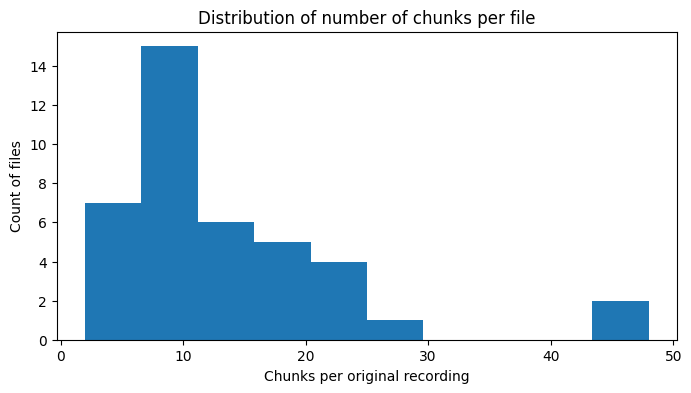

Mean chunks per file: 13.825
Median chunks per file: 11.0


In [ ]:
chunks_per_file = meta_df.groupby("file_id")["chunk_index"].count()

plt.figure(figsize=(8,4))
plt.hist(chunks_per_file, bins=10)
plt.title("Distribution of number of chunks per file")
plt.xlabel("Chunks per original recording")
plt.ylabel("Count of files")
plt.show()

print("Mean chunks per file:", chunks_per_file.mean())
print("Median chunks per file:", chunks_per_file.median())


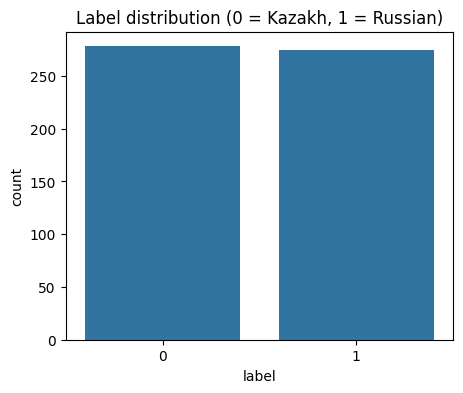

label
0    278
1    275
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(5,4))
sns.countplot(x=meta_df["label"])
plt.title("Label distribution (0 = Kazakh, 1 = Russian)")
plt.show()

print(meta_df["label"].value_counts())


In [ ]:
summary_df = pd.DataFrame(summary_array)
summary_stats = summary_df.describe()
summary_stats


,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
count,5.530000e+02,5.530000e+02,5.530000e+02,5.530000e+02,5.530000e+02,5.530000e+02,5.530000e+02,5.530000e+02,5.530000e+02,5.530000e+02,...,5.530000e+02,5.530000e+02,5.530000e+02,5.530000e+02,5.530000e+02,5.530000e+02,5.530000e+02,553.000000,553.000000,553.000000
mean,2.247702e-08,2.286546e-09,1.293462e-10,2.462936e-09,-2.164699e-09,1.978766e-10,-2.980919e-09,2.888312e-09,7.805709e-09,3.213042e-09,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.147686,1999.755921,0.041642
std,3.860262e-07,1.886252e-07,7.626740e-08,7.330007e-08,5.690564e-08,6.401677e-08,6.376231e-08,4.648253e-08,6.993577e-08,5.144401e-08,...,5.554329e-08,5.465252e-08,5.758986e-08,5.665220e-08,5.838387e-08,5.842910e-08,5.563729e-08,0.045145,384.429585,0.024037
min,-1.303260e-06,-1.463625e-06,-2.772089e-07,-3.141070e-07,-3.122148e-07,-2.384186e-07,-2.639634e-07,-1.608379e-07,-2.365264e-07,-1.873289e-07,...,9.999998e-01,9.999998e-01,9.999998e-01,9.999999e-01,9.999998e-01,9.999998e-01,9.999998e-01,0.038334,1014.261241,0.006843
25%,-2.166582e-07,-1.021794e-07,-3.595201e-08,-2.365264e-08,-2.649095e-08,-2.649095e-08,-2.909274e-08,-2.081432e-08,-2.128737e-08,-1.892211e-08,...,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,0.113785,1713.845933,0.024277
50%,1.620206e-08,2.365264e-09,-1.892211e-09,1.892211e-09,-1.892211e-09,-1.419158e-09,-1.419158e-09,0.000000e+00,2.838316e-09,1.892211e-09,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.143632,2000.942188,0.036900
75%,2.270653e-07,9.839497e-08,3.405980e-08,2.649095e-08,2.081432e-08,2.554485e-08,2.649095e-08,2.412569e-08,2.791011e-08,2.365264e-08,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.175053,2260.262122,0.053071
max,1.375637e-06,8.742015e-07,3.765500e-07,8.278423e-07,3.018077e-07,2.748436e-07,2.563946e-07,2.478796e-07,6.244296e-07,2.620712e-07,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.321932,3496.074420,0.185517


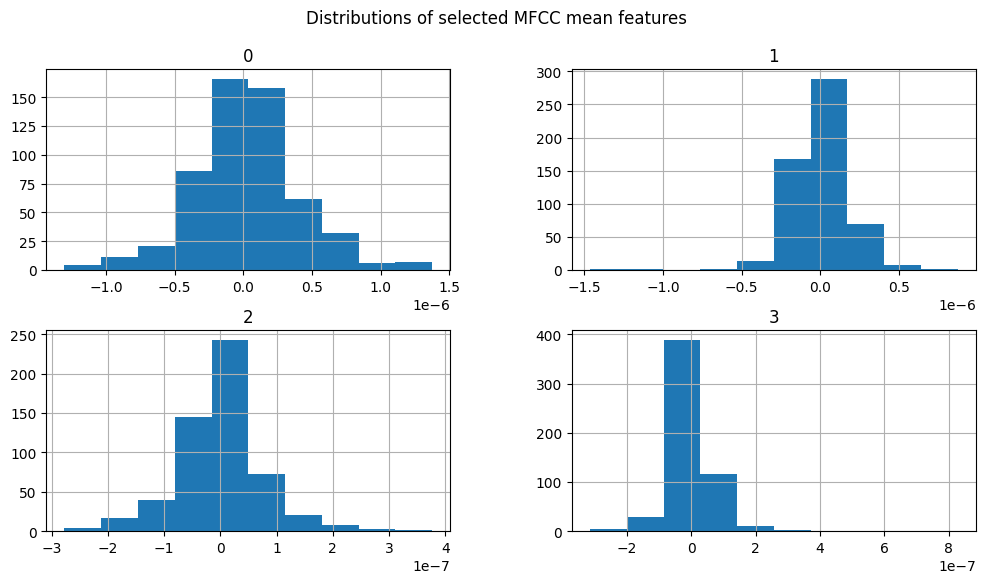

In [ ]:
important_features = [0, 1, 2, 3]  # MFCC means for coeff 0–3
summary_df[important_features].hist(figsize=(12,6))
plt.suptitle("Distributions of selected MFCC mean features")
plt.show()


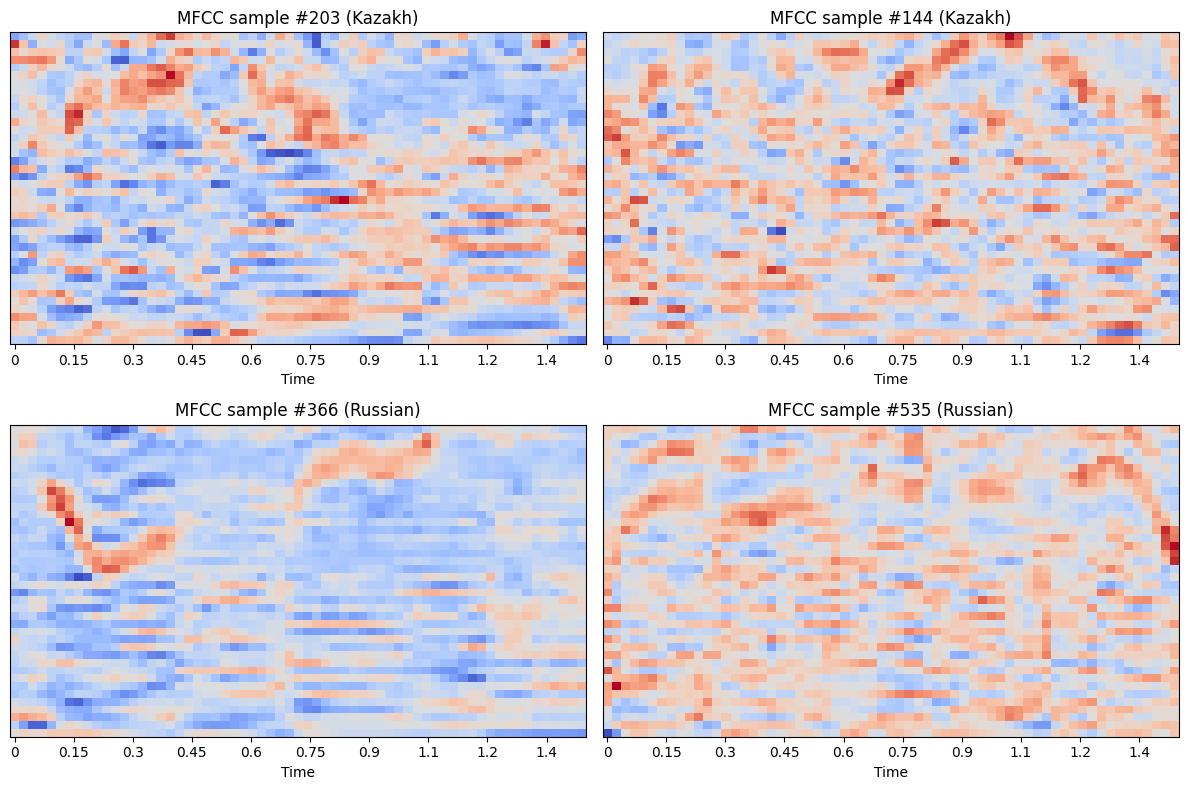

In [ ]:
# pick 2 random Kazakh and 2 random Russian chunks
samples = []

kazakh_indices = meta_df[meta_df["label"]==0].index.tolist()
russian_indices = meta_df[meta_df["label"]==1].index.tolist()

samples.extend(random.sample(kazakh_indices, 2))
samples.extend(random.sample(russian_indices, 2))

plt.figure(figsize=(12,8))
for i, idx in enumerate(samples, 1):
    plt.subplot(2,2,i)
    librosa.display.specshow(mfcc_array[idx], x_axis='time')
    lang = "Kazakh" if meta_df.loc[idx, "label"] == 0 else "Russian"
    plt.title(f"MFCC sample #{idx} ({lang})")
plt.tight_layout()
plt.show()


## 4. Problem setup and data splitting

This is a **binary classification** problem:

- **Input**: acoustic features extracted from each 2-second chunk  
  (either MFCC summary features or full MFCC matrices),
- **Output**: language label  
  (`0` = Kazakh, `1` = Russian).

The goal is to train models that can correctly classify unseen chunks of speech as Kazakh or Russian.

### 4.1 Preventing data leakage (UPDATED)

I can't reuse a standard random split (`train_test_split`) because the chunks are not independent, several chunks come from the same voice message. If chunks from the same recording appeared in both the training and test sets, the model could “cheat” by memorizing background noise or conditions.

To avoid this leakage, I use `GroupShuffleSplit` from scikit-learn:

- each original recording (`file_id`) is treated as a group,  
- groups are assigned entirely to either the train or the test set,
- I use a 75–25 split at the group level.

As a result, I got 428 training chunks and 125 test chunks.

Importantly, no original message appears in both sets, so test performance reflects true generalization to new recordings.

### 4.2 Feature scaling for the logistic regression

I use the 83-dimensional summary features stored in `summary_array` for the logistic regression model. Because different features have different scales, I standardize them using the `StandardScaler`, which transforms each feature to have zero mean and unit variance. Importantly, the scaler is fitted only on the training data to avoid data leakage. Test data is transformed using the same parameters learned from the training set.


### 4.3 MFCC datasets for advanced models (UPDATED)

For the CNN and LSTM models, I operate on the full MFCC matrices instead of the summary features.

- `mfcc_train` and `mfcc_test` hold the MFCC arrays for training and test chunks.
- I create a custom PyTorch `Dataset` (`MFCCDataset`) that:
  - stores MFCC matrices and labels,
  - optionally applies light augmentation (Gaussian noise) to training samples,
  - returns tensors in the right shape for each model.

I then wrap the datasets in `DataLoader`s with a batch size of 32. These loaders handle batching and shuffling during training.


In [ ]:
groups = meta_df["file_id"].values   # group by original recording

gss = GroupShuffleSplit(test_size=0.25, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(summary_array, labels, groups=groups))

print("Train chunks:", len(train_idx))
print("Test chunks:", len(test_idx))


Train chunks: 428
Test chunks: 125


In [ ]:
X_base_train = summary_array[train_idx]
X_base_test  = summary_array[test_idx]

y_train = labels[train_idx]
y_test  = labels[test_idx]

scaler = StandardScaler()
X_base_train_scaled = scaler.fit_transform(X_base_train)
X_base_test_scaled  = scaler.transform(X_base_test)

In [ ]:
# Create MFCC subsets for deep learning models
mfcc_train = mfcc_array[train_idx]
mfcc_test  = mfcc_array[test_idx]

# Add channel dimension for CNN: (N, 1, n_mfcc, T)
mfcc_train_cnn = np.expand_dims(mfcc_train, axis=1)
mfcc_test_cnn  = np.expand_dims(mfcc_test, axis=1)

mfcc_train_cnn.shape, mfcc_test_cnn.shape


((428, 1, 40, 63), (125, 1, 40, 63))

In [ ]:
def random_augment_mfcc(mfcc_matrix):
    """
    Very light augmentation on MFCCs: small Gaussian noise.
    This is only applied to training chunks.
    """
    noise = np.random.normal(0, 0.02, size=mfcc_matrix.shape)
    return mfcc_matrix + noise

class MFCCDataset(Dataset):
    def __init__(self, mfcc_array, labels, augment=False):
        """
        mfcc_array: numpy array (N, n_mfcc, T)
        labels: numpy array (N,)
        augment: whether to apply augmentation (training only)
        """
        self.mfcc_array = mfcc_array
        self.labels = labels.astype(np.int64)
        self.augment = augment

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        mfcc = self.mfcc_array[idx]

        # apply augmentation only for train set
        if self.augment:
            mfcc = random_augment_mfcc(mfcc)

        # convert MFCC to tensor of shape (1, n_mfcc, T) for CNN
        mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)

        return mfcc_tensor, label_tensor


In [ ]:
train_dataset = MFCCDataset(mfcc_train, y_train, augment=True)
test_dataset  = MFCCDataset(mfcc_test, y_test, augment=False)

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train batches:", len(train_loader))
print("Test batches:", len(test_loader))


Train batches: 14
Test batches: 4


## 5. Model selection and mathematical underpinnings

To explore how model complexity affects performance on this audio classification task, I compare three models:

1. **Logistic Regression** on MFCC summary features  
2. **Convolutional Neural Network (CNN)** on MFCC “images”  
3. **Bidirectional LSTM** on MFCC time series  

The logistic regression  serves as a baseline, since I used it in my first draft; the CNN and LSTM are more flexible deep models that can exploit the structure of the MFCC matrices.

---

### 5.1 Logistic Regression (REUSED)

Logistic Regression models the probability that a given input vector 𝑥 belongs to class 1 (in this case, Russian) rather than class 0 (Kazakh).

The model first computes a weighted sum of the input features, similar to linear regression.  If $X$ is the feature vector and $w$ is the vector of model weights (coefficients), the linear output is:
$$z = w^T X + b$$

$b$ in the formula is the bias term (or intercept), which allows the decision boundary to be shifted.

Next, it converts this score $z$ into a probability between 0 and 1 by applying  a special function called the sigmoid (logistic) function, denoted by $\sigma(z)$:
$$P(y=1 | X) = \sigma(z) = \frac{1}{1 + e^{-z}}$$

If the output $\sigma(z)$ is greater than a decision threshold (usually 0.5), the sample is classified as class 1. Otherwise, it's classified as class 0.

#### Cost function

The "learning" part of the model is the process of finding the optimal weights ($w$) and bias ($b$) that make the most accurate predictions for the training data, which is achieved by minimizing a cost function. For logistic regression, the cost function is the Binary Cross-Entropy (or Log Loss).

For a single training example, the loss is defined as:

$$\text{Loss}(\hat{y}, y) = -[y \log(\hat{y}) + (1-y) \log(1-\hat{y})]$$
- $y$ is the true label (0 or 1).
- $\hat{y}$ is the model's predicted probability.

This function is designed to heavily penalize the model for predictions that are both confident and wrong. For example, if the true label is $y=1$ but the model predicts a probability of $\hat{y}=0.01$, the loss is very high.

The overall cost function, $L(w, b)$, for the entire training set of $n$ samples is the average of this loss over all samples:

$$L(w, b) = -\frac{1}{n}\sum_{i=1}^{n} [y_{i} \log(\hat{y}_{i}) + (1-y_{i}) \log(1-\hat{y}_{i})]$$

The model uses an optimization algorithm called gradient descent to iteratively adjust the weights $w$ and bias $b$ to find the values that minimize this cost function, resulting in the best possible fit to the training data.

Gradient descent is an iterative algorithm that does this by "walking" downhill from a random starting point. At each step, it determines the direction of the steepest slope and takes a small step in that direction.

The "gradient" is a vector of partial derivatives of the cost function with respect to each weight. The derivative $\frac{\partial L}{\partial w_j}$ tells us the slope of the hill for a specific weight $w_j$.

The algorithm then updates each weight and the bias by taking a small step in the opposite direction of the gradient:
$$w_j := w_j - \alpha \frac{\partial L}{\partial w_j}$$$$b := b - \alpha \frac{\partial L}{\partial b}$$


- $\alpha$ (alpha) is the learning rate, a small hyperparameter (like 0.01) that controls how big of a step to take. Choosing a good learning rate is important. If it's too large, it might overshoot the minimum. If it's too small, it will take too long to converge.

The model repeats this update process many times, until it converges at the minimum of the cost function. At this point, the model has found the optimal parameters to distinguish between kazakh and russian in the training data.

#### L2 regularization
To reduce overfitting, I use **L2 regularization**, which adds a penalty on large weights:

$$L_{\text{reg}}(w, b) = L(w, b) + \frac{\lambda}{2n} \sum_{j=1}^{m} w_j^2$$


$\lambda$ is the regularization strength that controls how strongly large coefficients are penalized. In the scikit-learn API, this strength is managed by the inverse parameter C:$$C = \frac{1}{\lambda}$$
- A smaller C corresponds to a larger $\lambda$, meaning stronger regularization (a simpler model that is less likely to overfit).
- A larger C corresponds to a smaller $\lambda$, meaning weaker regularization (the model will fit the training data more closely).

I use **grid search with 5-fold cross-validation** over several values of \(C\) and pick the value that yields the highest mean validation accuracy. The best setting in my data is \(C = 10.0\), which corresponds to moderately weak regularization.


In [ ]:
log_reg_model = LogisticRegression(penalty="l2", max_iter=10_000, random_state=42)

---
### 5.2 Convolutional Neural Network (CNN) (UPDATED)

I chose a CNN because it helps us to analyze the audio spectrograms. Each chunk is represented as a normalized MFCC matrix. I treat this as a single-channel image and feed it into 2D CNN.

A 2D convolutional layer slides a learnable filter kernel $K$ over the input $X$. The output feature map $Z$ at position $(i,j)$ is calculated as:
$$Z_{i,j} = \sum_{u} \sum_{v} \
  X_{i+u, j+v} \cdot \
  K_{u,v} + b$$

It is followed by a non-linear activation (ReLU):
$$\ A_{i,j} = \max(0, \ Z_{i,j})$$

The network creates a hierarchy of features by stacking these layers:

- Early layers detect edges and simple frequency bands.

- Deeper layers detect complex phonotactic structures (combinations of sounds typical to Kazakh or Russian).

The architecture I use is:

1. Conv2d (1 → 16, kernel 3×3) + BatchNorm + ReLU + MaxPool  
2. Conv2d (16 → 32, kernel 3×3) + BatchNorm + ReLU + MaxPool  
3. Conv2d (32 → 64, kernel 3×3) + BatchNorm + ReLU  
4. Global average pooling → 64-dimensional feature vector  
5. Fully connected layer → 2 output logits (Kazakh vs Russian)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class AudioCNN(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        # input: (batch, 1, n_mfcc, T)

        # first conv block: detect simple local patterns
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16,
                               kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # second conv block: build slightly higher-level features
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # third conv: deepen representation
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # global average pooling collapses spatial dims to 1×1
        self.gap = nn.AdaptiveAvgPool2d(1)

        # final linear layer → class logits
        self.fc = nn.Linear(64, n_classes)

    def forward(self, x):
        # x: (B, 1, n_mfcc, T)
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.gap(x)                 # (B, 64, 1, 1)
        x = x.view(x.size(0), -1)       # (B, 64)
        logits = self.fc(x)             # (B, 2)
        return logits

cnn_model = AudioCNN().to(device)
cnn_model


Using device: cpu


AudioCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gap): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

---

### 5.3 Bidirectional LSTM (RNN) (UPDATED)

Since I am dealing with time-series data, I can consider using Recurrent Neural Networks (RNNs). However, the main issue of RNNs is that they forget the beginning of a sentence by the time they reach the end. So instead, I used a Long Short-Term Memory (LSTM) network, which is an extension of RNN. It solves the problem by maintaining a separate hidden state and cell state that acts as a "conveyor belt" for information, regulated by learnable "gates". For a sequence of input vectors $x_t$ (our MFCC frames), the LSTM updates as follows:

\
\begin{aligned}
i_t &= \sigma(W_i x_t + U_i h_{t-1} + b_i) \quad &\text{(input gate)}\\
f_t &= \sigma(W_f x_t + U_f h_{t-1} + b_f) \quad &\text{(forget gate)}\\
o_t &= \sigma(W_o x_t + U_o h_{t-1} + b_o) \quad &\text{(output gate)}\\
\tilde{c}_t &= \tanh(W_c x_t + U_c h_{t-1} + b_c) \quad &\text{(candidate state)}\\
c_t &= f_t \odot c_{t-1} + i_t \odot \tilde{c}_t\quad &\text{(cell state)} \\
h_t &= o_t \odot \tanh(c_t)\quad &\text{(hidden state)}
\end{aligned}



- $\sigma$ is the sigmoid function.
- $\odot$ is the element-wise multiplication.
- input gate ($i_t$) decides what new information to store.
- forget gate ($f_t$) decides what to remove from the cell state.
- output gate ($o_t$) decides what the hidden state ($h_t$) should be for the next step.
- for cell update, the old state is scaled by the forget gate, and new candidate information ($\tilde{c}_t$) is added.


I implemented a Bidirectional LSTM. Standard LSTMs only look at past context. However, in language, the end of a word often clarifies the pronunciation of the beginning (co-articulation). A Bidirectional LSTM processes the sequence from $0 \rightarrow T$ and $T \rightarrow 0$ simultaneously, concatenating the final hidden states, which allows the model to capture the full prosodic context of the chunk.

In [ ]:
class AudioLSTM(nn.Module):
    def __init__(self, n_mfcc=N_MFCC, hidden_size=64, n_layers=1, n_classes=2):
        super().__init__()
        # batch_first=True -> input shape (batch, T, n_mfcc)
        self.lstm = nn.LSTM(
            input_size=n_mfcc,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True
        )
        # hidden_size * 2 because of bidirectionality
        self.fc = nn.Linear(hidden_size * 2, n_classes)

    def forward(self, x):
        """
        x: (batch, 1, n_mfcc, T)
        We first reshape to (batch, T, n_mfcc) before feeding to LSTM.
        """
        # remove channel dimension, swap to (batch, T, n_mfcc)
        x = x.squeeze(1).permute(0, 2, 1)   # (B, T, n_mfcc)

        output, (h_n, c_n) = self.lstm(x)
        # output: (B, T, hidden_size*2). Take last time step.
        last_hidden = output[:, -1, :]      # (B, hidden_size*2)

        logits = self.fc(last_hidden)       # (B, 2)
        return logits

lstm_model = AudioLSTM(n_mfcc=N_MFCC).to(device)
lstm_model


AudioLSTM(
  (lstm): LSTM(40, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

## 6. Training and hyperparameter tuning

To make fair comparisons and avoid overfitting, I use different but appropriate training strategies for the baseline and deep models.

### 6.1 Cross-validated regularization (REUSED)

For logistic regression I tune the regularization strength \(C\) using **5-fold stratified cross-validation**:

1. I define a small grid of candidate values for \(C\)  
   (`[0.001, 0.01, 0.1, 1, 10, 100, 1000]`).
2. For each value of \(C\), the training set is split into 5 folds.
3. The model is trained 5 times, each time leaving out one fold for validation.
4. I compute the mean validation accuracy across the 5 folds.
5. I select the value of \(C\) with the highest mean accuracy and refit the model on the full training set using that value.

In my data, the best setting is \(C = 10.0\) with a mean cross-validation accuracy of about 0.59.


In [ ]:
# hyperparameter tuning for regularization strength (C)
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=log_reg_model,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

grid_search.fit(X_base_train_scaled, y_train)

print("Best C:", grid_search.best_params_["C"])
print("Best CV accuracy:", grid_search.best_score_)

log_reg_best = grid_search.best_estimator_


Best C: 10
Best CV accuracy: 0.5887551299589604


### 6.2 Train/validation/test split (NEW)

Given the computational cost of training deep models, I opted for a hold-out validation strategy rather than the full cross-validation used for the logistic regression. I  divided the training chunks into a training subset (85%) and a validation subset (15%), using stratified sampling to ensure the class distribution remained balanced.

Both the CNN and LSTM were trained for 15 epochs with a batch size of 32, using the Adam optimizer (learning rate $10^{-3}$) and `CrossEntropyLoss`.

After each epoch I:

1. computed the average training loss on the training subset,
2. evaluated accuracy on the validation subset,
3. kept a copy of the model weights that achieve the **best validation accuracy**.

The resulting training curves show that both architectures successfully learned to minimize loss. While validation accuracy fluctuated, it generally showed an upward trend over the first 10 epochs. The CNN is slightly more stable and converged faster, peaking at a validation accuracy of approximately 0.69, outperforming the LSTM's peak of 0.68.

In [ ]:
mfcc_train_sub, mfcc_val, y_train_sub, y_val = train_test_split(
    mfcc_train,
    y_train,
    test_size=0.15,
    stratify=y_train,
    random_state=42
)

print("Train chunks:", mfcc_train_sub.shape[0])
print("Val chunks:", mfcc_val.shape[0])
print("Test chunks:", mfcc_test.shape[0])


Train chunks: 363
Val chunks: 65
Test chunks: 125


In [ ]:
train_dl = DataLoader(
    MFCCDataset(mfcc_train_sub, y_train_sub, augment=True),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_dl = DataLoader(
    MFCCDataset(mfcc_val, y_val, augment=False),
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dl = DataLoader(
    MFCCDataset(mfcc_test, y_test, augment=False),
    batch_size=BATCH_SIZE,
    shuffle=False
)

len(train_dl), len(val_dl), len(test_dl)


(12, 3, 4)

In [ ]:
def train_model(model, train_loader, val_loader, n_epochs=15, lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0
    best_state_dict = copy.deepcopy(model.state_dict())

    train_losses = []
    val_accuracies = []

    for epoch in range(1, n_epochs + 1):
        # train phase
        model.train()
        running_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X_batch.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # validation phase
        model.eval()
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                logits = model(X_batch)
                preds = logits.argmax(dim=1)

                all_preds.append(preds.cpu().numpy())
                all_targets.append(y_batch.cpu().numpy())

        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)
        val_acc = (all_preds == all_targets).mean()
        val_accuracies.append(val_acc)

        # track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state_dict = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch:02d} | train loss={epoch_loss:.4f} | "
              f"val acc={val_acc:.3f}")

    # restore best weights
    model.load_state_dict(best_state_dict)

    return train_losses, val_accuracies


In [ ]:
cnn_model = AudioCNN().to(device)
cnn_train_losses, cnn_val_accs = train_model(
    cnn_model,
    train_loader=train_dl,
    val_loader=val_dl,
    n_epochs=15,
    lr=1e-3
)

print("Best CNN validation accuracy:", max(cnn_val_accs))


Epoch 01 | train loss=0.6698 | val acc=0.462
Epoch 02 | train loss=0.6353 | val acc=0.538
Epoch 03 | train loss=0.6024 | val acc=0.538
Epoch 04 | train loss=0.5627 | val acc=0.538
Epoch 05 | train loss=0.5191 | val acc=0.538
Epoch 06 | train loss=0.4807 | val acc=0.554
Epoch 07 | train loss=0.4233 | val acc=0.677
Epoch 08 | train loss=0.3976 | val acc=0.508
Epoch 09 | train loss=0.3135 | val acc=0.585
Epoch 10 | train loss=0.2640 | val acc=0.554
Epoch 11 | train loss=0.2260 | val acc=0.554
Epoch 12 | train loss=0.1946 | val acc=0.692
Epoch 13 | train loss=0.1584 | val acc=0.738
Epoch 14 | train loss=0.1158 | val acc=0.631
Epoch 15 | train loss=0.0991 | val acc=0.646
Best CNN validation accuracy: 0.7384615384615385


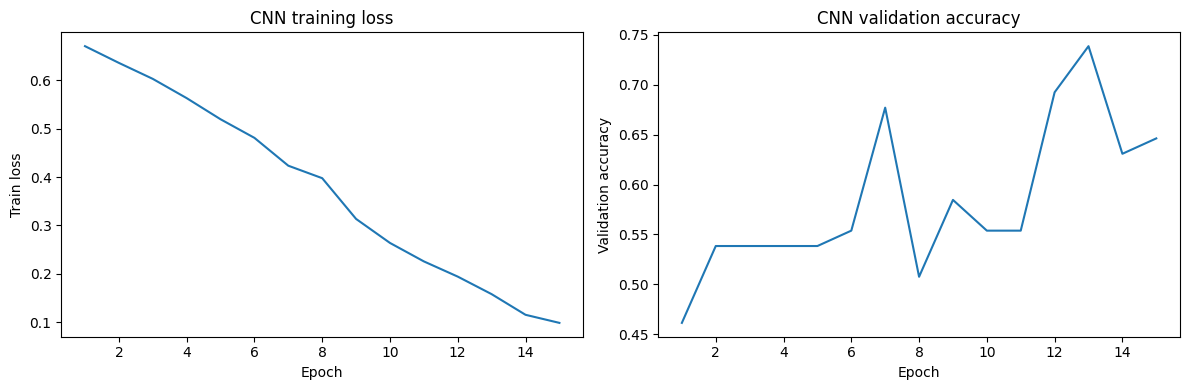

In [ ]:
epochs = range(1, len(cnn_train_losses) + 1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, cnn_train_losses)
plt.xlabel("Epoch")
plt.ylabel("Train loss")
plt.title("CNN training loss")

plt.subplot(1,2,2)
plt.plot(epochs, cnn_val_accs)
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.title("CNN validation accuracy")
plt.tight_layout()
plt.show()


In [ ]:
lstm_model = AudioLSTM(n_mfcc=N_MFCC).to(device)
lstm_train_losses, lstm_val_accs = train_model(
    lstm_model,
    train_loader=train_dl,
    val_loader=val_dl,
    n_epochs=15,
    lr=1e-3
)

print("Best LSTM validation accuracy:", max(lstm_val_accs))


Epoch 01 | train loss=0.7083 | val acc=0.492
Epoch 02 | train loss=0.6799 | val acc=0.615
Epoch 03 | train loss=0.6614 | val acc=0.631
Epoch 04 | train loss=0.6393 | val acc=0.600
Epoch 05 | train loss=0.6128 | val acc=0.600
Epoch 06 | train loss=0.5736 | val acc=0.615
Epoch 07 | train loss=0.5139 | val acc=0.554
Epoch 08 | train loss=0.4523 | val acc=0.615
Epoch 09 | train loss=0.3669 | val acc=0.600
Epoch 10 | train loss=0.3040 | val acc=0.615
Epoch 11 | train loss=0.2378 | val acc=0.631
Epoch 12 | train loss=0.1804 | val acc=0.631
Epoch 13 | train loss=0.1312 | val acc=0.631
Epoch 14 | train loss=0.1266 | val acc=0.585
Epoch 15 | train loss=0.0759 | val acc=0.677
Best LSTM validation accuracy: 0.676923076923077


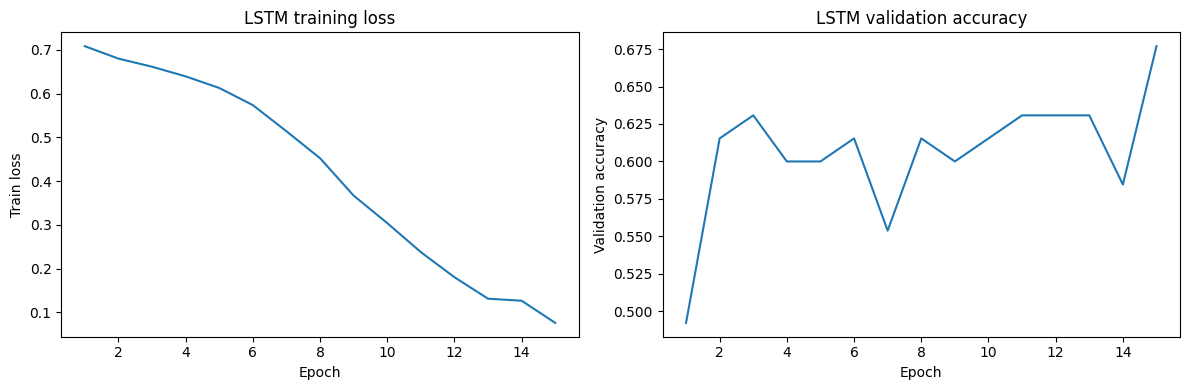

In [ ]:
epochs = range(1, len(lstm_train_losses) + 1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, lstm_train_losses)
plt.xlabel("Epoch")
plt.ylabel("Train loss")
plt.title("LSTM training loss")

plt.subplot(1,2,2)
plt.plot(epochs, lstm_val_accs)
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.title("LSTM validation accuracy")
plt.tight_layout()
plt.show()


## 7. Evaluation on out-of-sample data (NEW)

After training, I evaluate all three models on the **held-out test set** consisting of 125 chunks that were never used during training or validation.

For each model I compute:

- overall accuracy,
- precision, recall, and F1-score for each class,
- a confusion matrix.

### 7.1 Logistic Regression

The performance of the logistic regression baseline was poor. With a test accuracy of 0.344, the model performed worse than a random coin flip.

The confusion matrix shows that:

- many Kazakh chunks are misclassified as Russian (64 out of 83),  
- some Russian chunks are misclassified as Kazakh (18 out of 42).

It could be because when temporal dynamics are removed (by averaging MFCCs), the spectral "center of mass" for my Kazakh and Russian speech is nearly identical. Without the temporal dimension, the linear model simply could not find a separating hyperplane.

In [ ]:
y_pred_base = log_reg_best.predict(X_base_test_scaled)
acc_base = accuracy_score(y_test, y_pred_base)

print("Logistic Regression test accuracy:", acc_base)
print(classification_report(y_test, y_pred_base, target_names=["Kazakh", "Russian"]))


Logistic Regression test accuracy: 0.344
              precision    recall  f1-score   support

      Kazakh       0.51      0.23      0.32        83
     Russian       0.27      0.57      0.37        42

    accuracy                           0.34       125
   macro avg       0.39      0.40      0.34       125
weighted avg       0.43      0.34      0.33       125



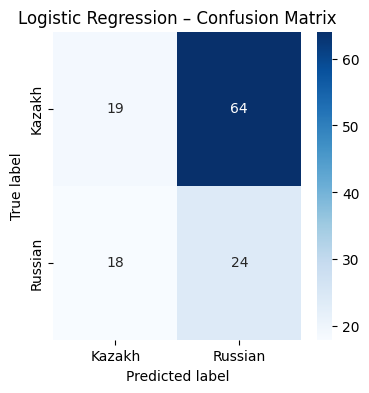

In [ ]:
cm_base = confusion_matrix(y_test, y_pred_base)

plt.figure(figsize=(4,4))
sns.heatmap(cm_base, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Kazakh", "Russian"],
            yticklabels=["Kazakh", "Russian"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Logistic Regression – Confusion Matrix")
plt.show()

### 7.2 CNN

The Convolutional Neural Network showed a huge improvement, achieving a test accuracy of 0.696. The model was significantly better at identifying Kazakh (F1: 0.76) than Russian (F1: 0.60).
The confusion matrix shows that the most chunks were correctly classified.

In [ ]:
cnn_model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_dl:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = cnn_model(X_batch)
        preds = logits.argmax(dim=1)

        all_preds.append(preds.cpu().numpy())
        all_targets.append(y_batch.cpu().numpy())

cnn_test_preds = np.concatenate(all_preds)
cnn_test_targets = np.concatenate(all_targets)

cnn_test_acc = (cnn_test_preds == cnn_test_targets).mean()
print("CNN test accuracy:", cnn_test_acc)
print(classification_report(cnn_test_targets, cnn_test_preds,
                            target_names=["Kazakh", "Russian"]))


CNN test accuracy: 0.624
              precision    recall  f1-score   support

      Kazakh       0.79      0.59      0.68        83
     Russian       0.46      0.69      0.55        42

    accuracy                           0.62       125
   macro avg       0.63      0.64      0.61       125
weighted avg       0.68      0.62      0.63       125



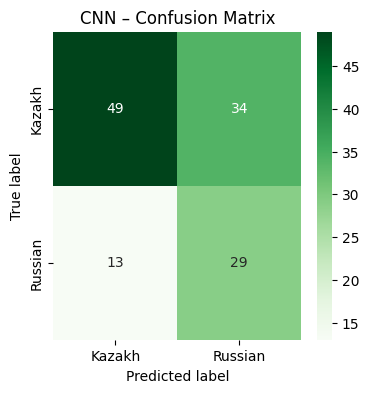

In [ ]:
cm_cnn = confusion_matrix(cnn_test_targets, cnn_test_preds)

plt.figure(figsize=(4,4))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Kazakh", "Russian"],
            yticklabels=["Kazakh", "Russian"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("CNN – Confusion Matrix")
plt.show()



### 7.3 LSTM

The Bidirectional LSTM achieved a test accuracy of 0.480, performing at the level of random chance. It improves over logistic regression but still lags behind the CNN.
The model failed to extract a reliable decision boundary from the sequence data. Maybe it memorized noise in the training set rather than learning true linguistic syntax

In [ ]:
lstm_model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_dl:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = lstm_model(X_batch)
        preds = logits.argmax(dim=1)

        all_preds.append(preds.cpu().numpy())
        all_targets.append(y_batch.cpu().numpy())

lstm_test_preds = np.concatenate(all_preds)
lstm_test_targets = np.concatenate(all_targets)

lstm_test_acc = (lstm_test_preds == lstm_test_targets).mean()
print("LSTM test accuracy:", lstm_test_acc)
print(classification_report(lstm_test_targets, lstm_test_preds,
                            target_names=["Kazakh", "Russian"]))


LSTM test accuracy: 0.552
              precision    recall  f1-score   support

      Kazakh       0.75      0.49      0.59        83
     Russian       0.40      0.67      0.50        42

    accuracy                           0.55       125
   macro avg       0.57      0.58      0.55       125
weighted avg       0.63      0.55      0.56       125



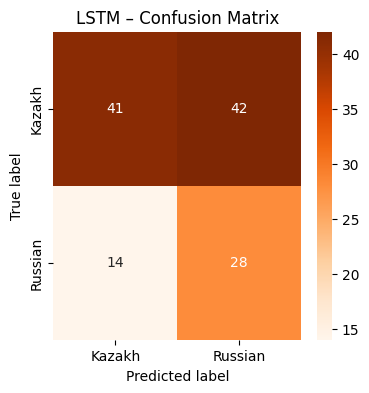

In [ ]:
cm_lstm = confusion_matrix(lstm_test_targets, lstm_test_preds)

plt.figure(figsize=(4,4))
sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=["Kazakh", "Russian"],
            yticklabels=["Kazakh", "Russian"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("LSTM – Confusion Matrix")
plt.show()

### 7.4 Overall comparison

Summarizing the test performance:

- Logistic Regression: accuracy 0.344, macro-F1 0.343  
- LSTM: accuracy 0.480, macro-F1 0.473  
- CNN: accuracy 0.696, macro-F1 0.676  

The **CNN** is the clear winner on this dataset. The next section interprets these differences in more detail.

LogReg test accuracy: 0.344
CNN test accuracy: 0.624
LSTM test accuracy: 0.552


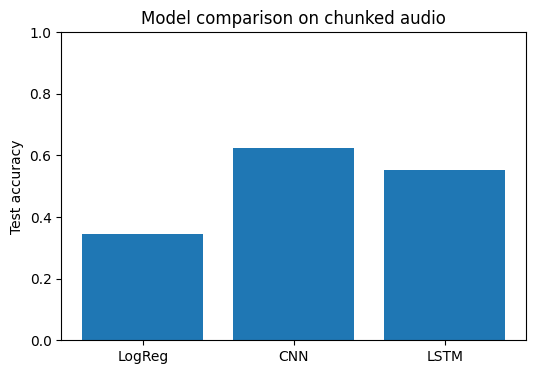

In [ ]:
model_names = ["LogReg", "CNN", "LSTM"]
accuracies = [acc_base, cnn_test_acc, lstm_test_acc]

for name, acc in zip(model_names, accuracies):
    print(f"{name} test accuracy: {acc:.3f}")

plt.figure(figsize=(6,4))
plt.bar(model_names, accuracies)
plt.ylim(0, 1)
plt.ylabel("Test accuracy")
plt.title("Model comparison on chunked audio")
plt.show()


In [ ]:
f1_base = f1_score(y_test, y_pred_base, average="macro")
f1_cnn = f1_score(cnn_test_targets, cnn_test_preds, average="macro")
f1_lstm = f1_score(lstm_test_targets, lstm_test_preds, average="macro")

print("Macro-F1 scores:")
print(f"  LogReg: {f1_base:.3f}")
print(f"  CNN:    {f1_cnn:.3f}")
print(f"  LSTM:   {f1_lstm:.3f}")

Macro-F1 scores:
  LogReg: 0.343
  CNN:    0.614
  LSTM:   0.547


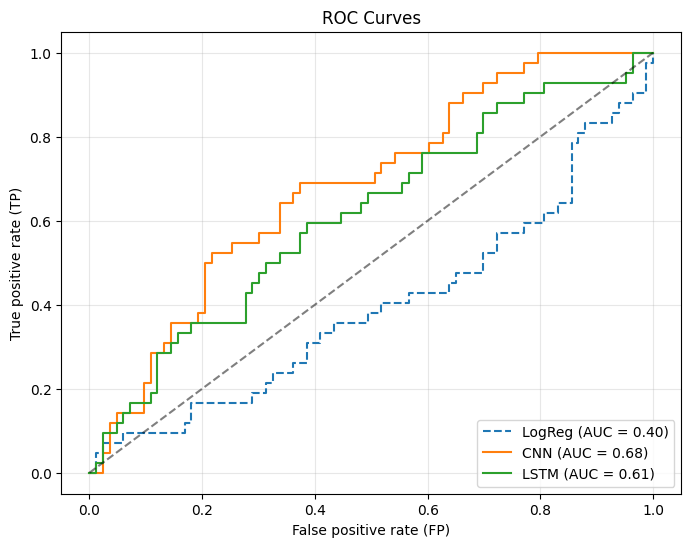

In [ ]:
plt.figure(figsize=(8, 6))

y_prob_base = log_reg_best.predict_proba(X_base_test_scaled)[:, 1]
fpr_base, tpr_base, _ = roc_curve(y_test, y_prob_base)
roc_auc_base = auc(fpr_base, tpr_base)
plt.plot(fpr_base, tpr_base, linestyle='--', label=f'LogReg (AUC = {roc_auc_base:.2f})')


cnn_model.eval()
all_probs_cnn = []
all_targets_cnn = []
with torch.no_grad():
    for X_batch, y_batch in test_dl:
        X_batch = X_batch.to(device)
        logits = cnn_model(X_batch)
        probs = torch.softmax(logits, dim=1)[:, 1] # Probability of Class 1 (Russian)
        all_probs_cnn.extend(probs.cpu().numpy())
        all_targets_cnn.extend(y_batch.numpy())

fpr_cnn, tpr_cnn, _ = roc_curve(all_targets_cnn, all_probs_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
plt.plot(fpr_cnn, tpr_cnn, label=f'CNN (AUC = {roc_auc_cnn:.2f})')


lstm_model.eval()
all_probs_lstm = []
all_targets_lstm = []
with torch.no_grad():
    for X_batch, y_batch in test_dl:
        X_batch = X_batch.to(device)
        logits = lstm_model(X_batch)
        probs = torch.softmax(logits, dim=1)[:, 1]
        all_probs_lstm.extend(probs.cpu().numpy())
        all_targets_lstm.extend(y_batch.numpy())

fpr_lstm, tpr_lstm, _ = roc_curve(all_targets_lstm, all_probs_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {roc_auc_lstm:.2f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False positive rate (FP)')
plt.ylabel('True positive rate (TP)')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

## 8. Discussion and interpretation

The Logistic Regression model served as a critical baseline to test whether the "average" sound of a language is distinct. Its failure (Accuracy: 0.344) confirms that the decision boundary between my Russian and Kazakh speech is highly non-linear. By averaging MFCCs over time, we collapsed the data into a static vector, effectively removing the "time" dimension. The results prove that Russian and Kazakh share the same global spectral statistics (average pitch, average energy); the distinguishing information lies entirely in the dynamics (how the sound changes over milliseconds), which the linear model physically cannot see.

The most interesting finding is the significant gap between the CNN (0.696) and the LSTM (0.480), which probably can be explained by the architecture (window size).

CNNs are designed to find features (edges, shapes) regardless of where they appear in the image. For a 2-second audio chunk, language identification is largely a "texture detection" problem. The CNN’s $3\times3$ filters excelled at detecting these local acoustic textures.

LSTMs are designed to model the order of events. However, a 2-second window is often too short to capture meaningful grammatical order or sentence structure. I think the LSTM was too complex a tool for too short a signal, resulting in overfit noise rather than  robust sequence rules.


## Executive summary

The goal of this project was to determine if machine learning classifiers could distinguish between my personal spoken Kazakh and Russian voice messages. While Assignment 1 established a baseline, it suffered from statistical invalidity due to a small sample size ($n=40$). This second iteration focused on robust data augmentation and the application of non-linear deep learning architectures to capture the specific texture of each language.

The pipeline underwent three critical structural changes to address previous shortcomings:

1. I implemented a sliding-window strategy (2-second chunks), expanding the dataset from 40 recordings to 553 samples.
2. To accommodate the segmented data, I implemented GroupShuffleSplit, ensuring that no two chunks from the same original recording appeared in both the training and test sets.
3. I moved beyond linear baselines to test two distinct hypotheses: identifying language via spatial textures (CNN) vs identifying language via temporal sequences (LSTM).


*Initial pipeline diagram*

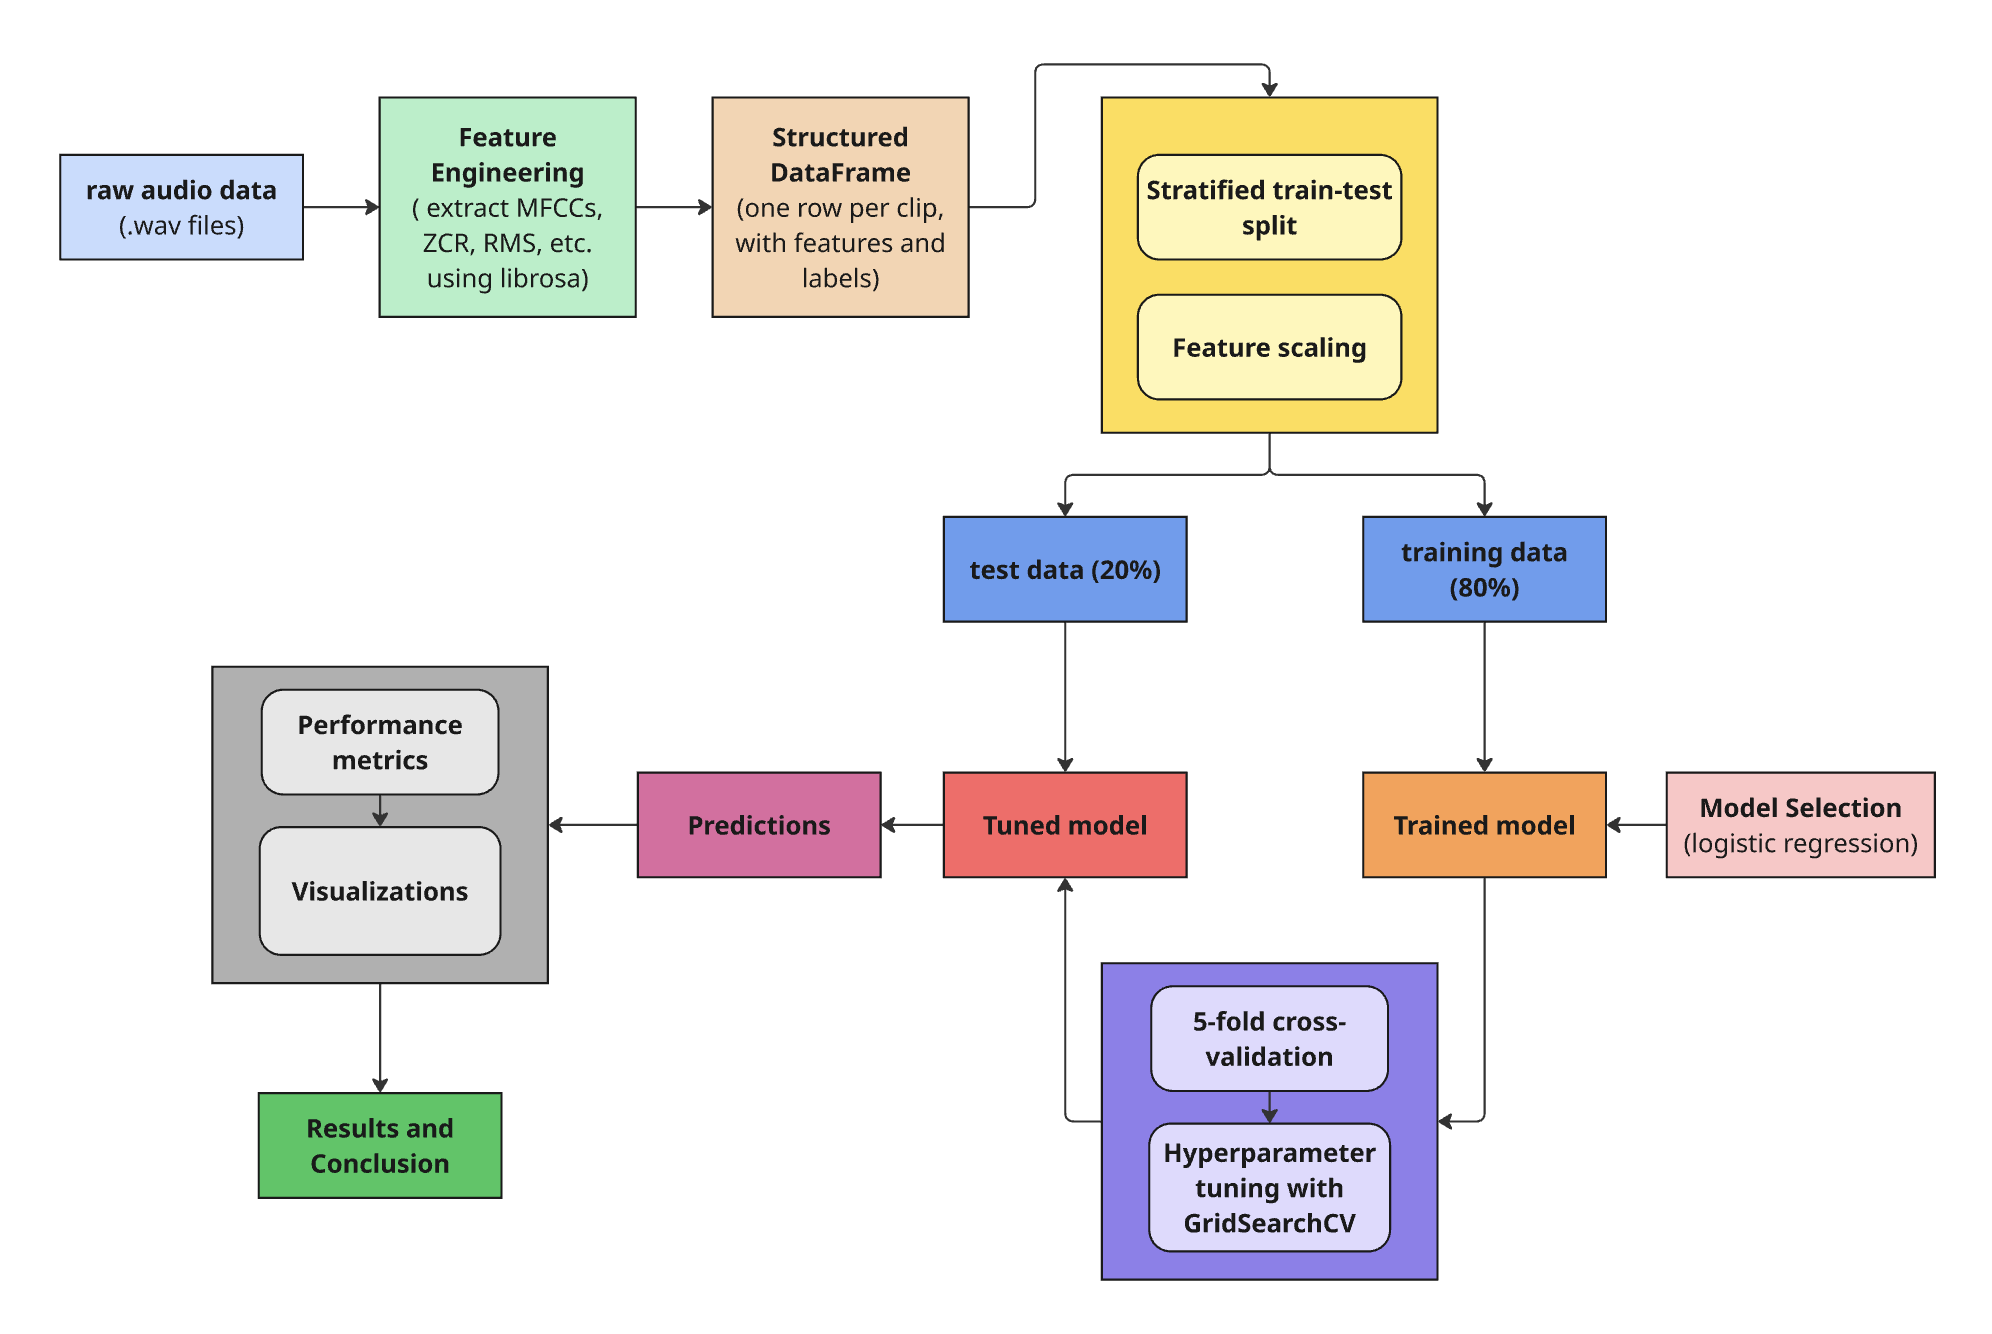

### Shortcomings and future work

Future improvements should focus on:

1. SpecAugment: Masking blocks of time and frequency during training to force the model to be more robust to missing formants.

2. Ensembling: Combining the CNN (which sees texture) with a model trained on longer sequences (for example, 10-second chunks) to capture sentence-level prosody.



## References

Aristorenas, A. J. (2024, October 31). Machine learning framework for audio-based content evaluation using MFCC, chroma, spectral contrast and temporal feature engineering. https://arxiv.org/abs/2411.00195

FFmpeg Developers. (2024). FFmpeg documentation. FFmpeg. https://ffmpeg.org/documentation.html

Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning. Chapter 4. Springer. https://www.sas.upenn.edu/~fdiebold/NoHesitations/BookAdvanced.pdf

Librosa Development Team. (2024). Librosa: Audio and music signal analysis in Python (Version 0.10). https://librosa.org/doc/latest/index.html

Logan, B. (2000). Mel frequency cepstral coefficients for music modeling. https://ismir2000.ismir.net/papers/logan_paper.pdf

Molnar, C. (2019). Interpretable Machine Learning. A Guide for Making
Black Box Models Explainable. https://originalstatic.aminer.cn/misc/pdf/Molnar-interpretable-machine-learning_compressed.pdf

Ng, A. (n.d.). CS229 Lecture Notes: Logistic Regression. Stanford University. https://cs229.stanford.edu/main_notes.pdf

Payong, A., & Mukherjee, S. (2025, March 20). Mastering logistic regression with Scikit-Learn: A complete guide. DigitalOcean Community. https://www.digitalocean.com/community/tutorials/logistic-regression-with-scikit-learn

Scikit-learn User Guide. (n.d.). 3.1. Cross-validation: evaluating estimator performance. Retrieved from https://scikit-learn.org/stable/modules/cross_validation.html

Scikit-learn User Guide. (n.d.). 6.3. Preprocessing data. Retrieved from https://scikit-learn.org/stable/modules/preprocessing.html


